In [87]:
import torch
import matplotlib.pyplot as plt
from vap.modules.VAP import step_extraction
from vap.modules.lightning_module import VAPModule
from vap.utils.audio import load_waveform
from vap.utils.plot import plot_stereo
from vap.data.datamodule import stereo_mixer_with_delay

def load_vap_model(checkpoint):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = VAPModule.load_model(checkpoint, map_location=device)
    return model.eval()

def run_inference(model, waveform, chunk_time=20, step_time=19.9):
    device = next(model.parameters()).device
    waveform = waveform.to(device)
    return step_extraction(waveform, model, chunk_time=chunk_time, step_time=step_time)

def create_plot(output, waveform, title):
    plt.figure(figsize=(10, 5))
    plot_stereo(
        waveform[0],
        p_now=output["p_now"][0].cpu(),
        p_fut=output["p_future"][0].cpu(),
        vad=output["vad"][0].cpu()
    )
    plt.title(title)
    plt.show()

In [88]:
# Configuration
config = {
    "audio_path": "/home/serhan/Desktop/VoiceActivityProjection/notebooks/audio.wav",
    "original_checkpoint": "/home/serhan/Desktop/Original/VoiceActivityProjection/example/checkpoints/checkpoint.ckpt",
    "new_checkpoint": "/home/serhan/Desktop/VoiceActivityProjection/serhan-utils/checkpoints/audio_mixed/full_mixed_e18_s206738.ckpt",
    "chunk_time": 20,
    "step_time": 0.1,
    "audio_mixer": True  # Set this to False to disable stereo mixing
}

In [89]:
# Load the Models
print("Loading Models...")
original_model = load_vap_model(config["original_checkpoint"])
new_model = load_vap_model(config["new_checkpoint"])

if torch.cuda.is_available():
    original_model = original_model.cuda()
    new_model = new_model.cuda()
    print("Models moved to CUDA")

Loading Models...
Models moved to CUDA


/home/serhan/miniconda3/envs/cleanvap/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [90]:
# Load the Audio
print("Loading Audio...")
waveform, sample_rate = load_waveform(config["audio_path"], sample_rate=original_model.sample_rate, mono=False)

print(f"Loaded waveform shape: {waveform.shape}")
print(f"Sample rate: {sample_rate}")

if config["audio_mixer"]:
    print("Applying stereo mixing...")
    waveform = stereo_mixer_with_delay(waveform, sample_rate)
else:
    print("Skipping stereo mixing...")

# Ensure waveform has shape (batch_size, channels, samples)
if waveform.dim() == 2:
    waveform = waveform.unsqueeze(0)
elif waveform.dim() == 3:
    if waveform.size(0) == 2:  # If channels are in the first dimension
        waveform = waveform.transpose(0, 1).unsqueeze(0)
else:
    raise ValueError(f"Unexpected waveform shape: {waveform.shape}")

print(f"Final waveform shape: {waveform.shape}")

duration = round(waveform.shape[-1] / sample_rate)
print(f"Audio duration: {duration} seconds")

Loading Audio...
Loaded waveform shape: torch.Size([2, 8787673])
Sample rate: 16000
Applying stereo mixing...
Final waveform shape: torch.Size([1, 2, 8787673])
Audio duration: 549 seconds


In [82]:
waveform

tensor([[[ 0.0000e+00,  0.0000e+00,  3.0518e-05,  ..., -1.9188e-02,
          -1.9755e-02, -2.1737e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.3382e-04,
           1.1895e-04,  4.4608e-05]]])

In [83]:
waveform.unsqueeze(0).shape

torch.Size([1, 1, 2, 8787673])

In [84]:
# Run inference for both models
print("Running inference for original model...")
output_orig = run_inference(original_model, waveform, config["chunk_time"], config["step_time"])

print("Running inference for new model...")
output_new = run_inference(new_model, waveform, config["chunk_time"], config["step_time"])

Running inference for original model...
folds:  (106, 1, 2, 320000)


Context: 15s, step: 5: 100%|██████████| 105/105 [00:04<00:00, 21.13it/s]


Running inference for new model...
folds:  (106, 1, 2, 320000)


Context: 15s, step: 5: 100%|██████████| 105/105 [00:04<00:00, 21.12it/s]


Creating plot for original model...


<Figure size 1000x500 with 0 Axes>

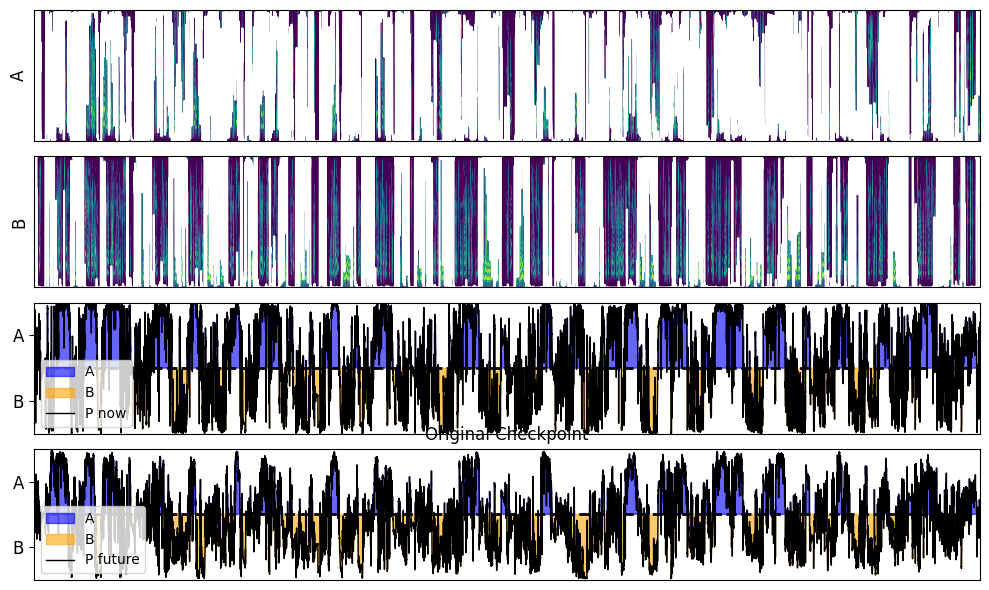

In [85]:
# Create plots
print("Creating plot for original model...")
create_plot(output_orig, waveform, "Original Checkpoint")

Creating plot for new model...


<Figure size 1000x500 with 0 Axes>

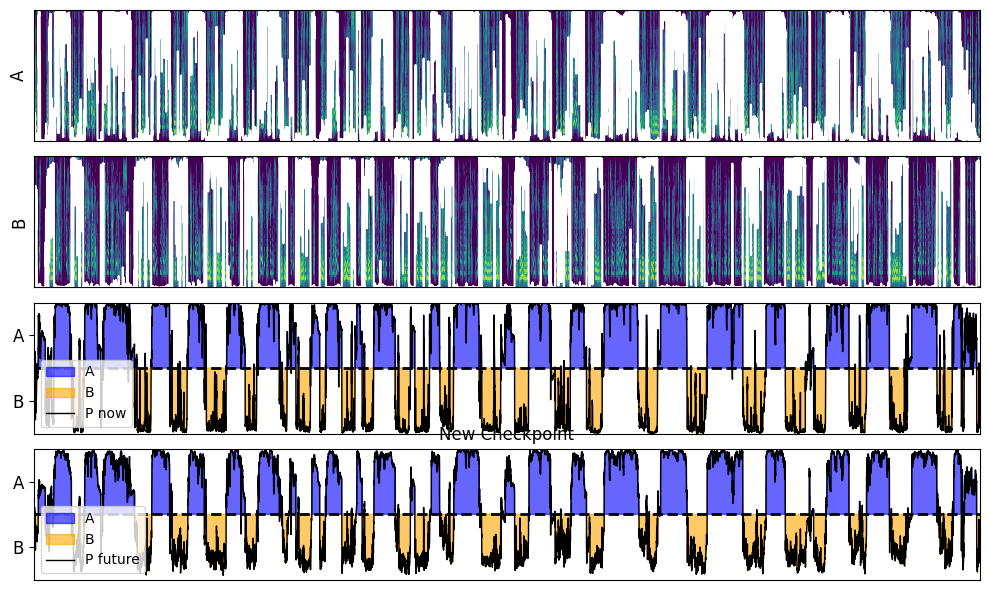

In [86]:
print("Creating plot for new model...")
create_plot(output_new, waveform, "New Checkpoint")